# Соревнование по ML "Alice"

Здесь я привожу своё решение соревнования по ML "Alice" от ODS в рамках курса Open ML Course: Линейные модели. Оно основано на baseline Notebook by Yuri Kashnitsky, edited by Ivan Komarov, но с моей доработкой.

Суть конкурса - идентификация пользователя в Интернете по последовательности переходов по сайтам. 

**Постановка задачи:** Для каждой сессии нужно предсказать, принадлежит ли сессия Alice (метка «1»), или нет (метка «0»).

**Последовательность решения задачи:** 

1. Загрузка и предобработка данных;
2. Анализ данных по "Домашнему заданию" от ODS;
3. Создание признаков:
    - На основе названий сайтов;
    - На основе времени сеансов;
    - На основе повторяемости сайтов
4. Обучение моделей с подбором гиперпараметров.

In [1]:
# Импорт библиотек
%matplotlib inline
from matplotlib import pyplot as plt

import pickle
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

from sklearn.utils import shuffle

from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, GridSearchCV
from scipy.stats import randint

from xgboost import XGBClassifier

Тетрадь на основе Notebook by Yuri Kashnitsky, edited by Ivan Komarov. 

In this competition we are going to analyze a sequence of websites visited by a person to predict whether this person is Alice or not. The metric of evaluation is [ROC AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic). 

##  Загрузка и преобразование данных 
Загрузим тренировочный и тестовый датасет, а также словать сайтов.

In [2]:
# Список названий колонок times
times = ['time'+str(i) for i in range(1,11)]
times

['time1',
 'time2',
 'time3',
 'time4',
 'time5',
 'time6',
 'time7',
 'time8',
 'time9',
 'time10']

In [3]:
# Загрузка данных и преобразование колонок содержащих дату и время в тип datetime
train_df = pd.read_csv('train.csv',
                       index_col='session_id', parse_dates=times)

test_df = pd.read_csv('test.csv',
                      index_col='session_id', parse_dates=times)

# Сортировка данных по дате
train_df = train_df.sort_values(by='time1')

# Посмотрим на тестовый датасет
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
27554,41475,2013-11-15 07:39:35,6725.0,2013-11-15 07:39:35,6725.0,2013-11-15 07:39:36,41475.0,2013-11-15 07:39:36,41476.0,2013-11-15 07:39:40,...,2013-11-15 07:39:41,6725.0,2013-11-15 07:42:50,41475.0,2013-11-15 07:42:50,41476.0,2013-11-15 07:42:50,6725.0,2013-11-15 07:44:25,0
81350,41476,2013-11-15 07:44:25,41475.0,2013-11-15 07:44:25,41476.0,2013-11-15 07:57:45,6725.0,2013-11-15 07:57:45,41475.0,2013-11-15 07:57:45,...,2013-11-15 07:57:46,41476.0,2013-11-15 07:57:47,6725.0,2013-11-15 07:57:49,41475.0,2013-11-15 07:57:49,41476.0,2013-11-15 07:57:49,0
234665,4802,2013-11-15 07:52:17,23.0,2013-11-15 07:52:18,4803.0,2013-11-15 07:52:19,38.0,2013-11-15 07:52:19,38.0,2013-11-15 07:52:20,...,2013-11-15 07:52:20,4804.0,2013-11-15 07:52:23,21.0,2013-11-15 07:52:26,23.0,2013-11-15 07:52:26,22.0,2013-11-15 07:52:28,0
97610,23,2013-11-15 07:52:28,23.0,2013-11-15 07:52:29,22.0,2013-11-15 07:52:37,21.0,2013-11-15 07:52:37,63.0,2013-11-15 07:55:10,...,2013-11-15 07:55:10,784.0,2013-11-15 07:55:56,4804.0,2013-11-15 07:57:50,4804.0,2013-11-15 08:01:18,784.0,2013-11-15 08:01:26,0
161358,41476,2013-11-15 07:57:50,41476.0,2013-11-15 07:57:51,6725.0,2013-11-15 07:59:34,41475.0,2013-11-15 07:59:34,41476.0,2013-11-15 07:59:34,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 27554 to 11690
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   site1   253561 non-null  int64         
 1   time1   253561 non-null  datetime64[ns]
 2   site2   250098 non-null  float64       
 3   time2   250098 non-null  datetime64[ns]
 4   site3   246919 non-null  float64       
 5   time3   246919 non-null  datetime64[ns]
 6   site4   244321 non-null  float64       
 7   time4   244321 non-null  datetime64[ns]
 8   site5   241829 non-null  float64       
 9   time5   241829 non-null  datetime64[ns]
 10  site6   239495 non-null  float64       
 11  time6   239495 non-null  datetime64[ns]
 12  site7   237297 non-null  float64       
 13  time7   237297 non-null  datetime64[ns]
 14  site8   235224 non-null  float64       
 15  time8   235224 non-null  datetime64[ns]
 16  site9   233084 non-null  float64       
 17  time9   233084 non-null  d

Тренировочный датасет содержит следующие признаки:

- **site1** – ID первого посещённого сайта во время сессии
- **time1** – время первого посещённого сайта во время сессии
- ...
- **site10** – ID десятого посещённого сайта во время сессии
- **time10** – время десятого посещённого сайта во время сессии
- **target** – целевой признак, **1** - сессия Alice,  **0** другие пользователи
    
**Пользовательские сеансы заканчиваются либо в том случае, если пользователь посетил десять веб-сайтов, либо в том случае, если сеанс длился более тридцати минут.**

В таблице есть несколько пропущеных значений, это означает, что некоторые сеансы содержат менее десяти веб-сайтов. Заменим пустые значения на 0 и изменим типы столбцов на целочисленные. Припуски в колонках с временем сеансов тоже заполним нулями. Также загрузм словарь веб-сайтов и проверим, как он выглядит:

In [5]:
# Заполнение пропусков в колонках site1, ..., site10 и изменяем тип
sites = ['site'+str(i) for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')
# Заполнение пропусков в колонках time1, ..., time10
train_df[times] = train_df[times].fillna(0)
test_df[times] = test_df[times].fillna(0)

# Загрузка словаря вёбсайтов
with open(r"site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)
  
print('Размер словаря:', len(site_dict))

Размер словаря: 48371


In [6]:
# Посмотрим на словарь
list(site_dict.items())[:5]

[('www.abmecatronique.com', 25075),
 ('groups.live.com', 13997),
 ('majeureliguefootball.wordpress.com', 42436),
 ('cdt46.media.tourinsoft.eu', 30911),
 ('www.hdwallpapers.eu', 8104)]

**Вывод** 

Данные загружены, произведена предобработка данных.

## Анализ данных

Ответим на воприсы из домашнего задания и проведём дополнительный анализ данных.

### Ответы на вопросы к домашнему заданию курса Open ML Course: Линейные модели

Ответим на следующие вопросы:
1. Какой процент сессий Элис из всех сессий?
2. В какой день недели Элис появилась в первый раз?
3. Какие года присутствуют в обучающей выборке?
4. Какой сайт в обучающей выборке чаще всего посещает первым Элис и обычный пользователь?
5. Какой сайт в обучающей выборке является вторым по популярности в 2014 году и сколько раз его посещали в 2014 году?
6. Сколько всего сессий обучающей выборки содержат в себе меньше чем 10 сайтов?
7. Выберите верные утверждения для обучающей выборки:
    - В среднем Элис проводит меньше времени на первой странице, чем другие пользователи;
    - Медианная длительность посещения первой страницы у не-Элис больше, чем у Элис;
    - Лето является самым малоактивным временем года вообще;
    - Элис наиболее активна в марте и неактивна летом;
8. Чему равное медианное значение количества уникальных сайтов в рамках одной сессии обучающей выборки?
9. Чему равное медианное значение времени сессии в обучающей выборке (время посещения последнего сайта примем равным нулю)?
10. В каком месяце доля сессий Элис среди всех сессий наибольшая?

#### Какой процент сессий Элис из всех сессий?

0.00905896411514389

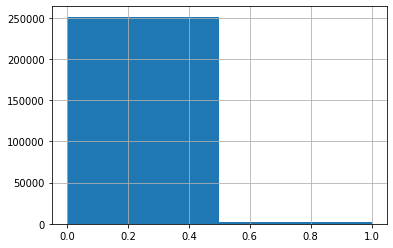

In [7]:
train_df['target'].hist(bins=2)
train_df[train_df['target'] == 1 ].shape[0] / train_df['target'].shape[0]

**Ответ:** Тренировочная выборка содержит 0.9% сессий Элис.

#### В какой день недели Элис появилась в первый раз?

Так как данные отсортированы по времени первого сайта в сеансе, достаточно отфильтровать по целевому признаку, взять первую строку и определить день недели.

In [8]:
train_df[train_df['target'] == 1]['time1'].head(1).dt.dayofweek

session_id
79635    4
Name: time1, dtype: int64

**Ответ:**  Элис появилась в первый раз в пятницу.

#### Какие года присутствуют в обучающей выборке?

In [9]:
train_df['time1'].dt.year.unique()

array([2013, 2014])

**Ответ:** В обучающей выборке присутствуют 2013 и 2014 года.

#### Какой сайт в обучающей выборке чаще всего посещает первым Элис и обычный пользователь?

In [10]:
# Создадим обратный словарь сайтов. Он пригодится и в будущем

new_dict = {}
for key in site_dict:
    new_dict[site_dict[key]] = key

In [11]:
print('Самый частый первый сайт Элис:', new_dict[train_df[train_df['target'] == 1]['site1'].value_counts().index[0]])

Самый частый первый сайт Элис: s.youtube.com


In [12]:
print('Самый частый первый сайт не Элис:', new_dict[train_df[train_df['target'] == 0]['site1'].value_counts().index[0]])

Самый частый первый сайт не Элис: www.google.fr


**Ответ:** В обучающей выборке Элис чаще всего посещает `s.youtube.com`, а обычный пользователь `www.google.fr`

#### Какой сайт в обучающей выборке является вторым по популярности в 2014 году и сколько раз его посещали в 2014 году?

In [13]:
sites_2014 =  pd.DataFrame(train_df[train_df['time1'].dt.year == 2014][sites[0]].value_counts())
for site in sites:
    sites_2014[site] = train_df[train_df['time1'].dt.year == 2014][site].value_counts()

In [14]:
sites_2014['sum'] = sites_2014[sites].apply(sum, axis=1)

sites_2014.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,sum
21,9714,9534.0,8935.0,8597.0,8585.0,8495.0,8297.0,8058.0,8057.0,7818.0,86090.0
782,7767,7704.0,7666.0,7634.0,7683.0,7749.0,7723.0,7700.0,7751.0,7662.0,77039.0
23,5945,5839.0,5746.0,6156.0,5878.0,5591.0,5498.0,5396.0,5096.0,5188.0,56333.0
780,4084,3972.0,4084.0,4103.0,4093.0,4040.0,4052.0,4081.0,4033.0,4068.0,40610.0
167,4051,4188.0,3924.0,3699.0,3797.0,3497.0,3554.0,3463.0,3462.0,3361.0,36996.0


In [15]:
new_dict[sites_2014.index[1]]

'annotathon.org'

**Ответ:** Вторым по популярности в 2014 году сайтом является `annotathon.org`. В 2014 году его посещали 77039 раз.

#### Сколько всего сессий обучающей выборки содержат в себе меньше чем 10 сайтов?

In [16]:
train_df[train_df['site10'] == 0]['site10'].count()

22509

**Ответ:** Всего в обучающей выборке 22509 сессий содержат в себе меньше чем 10 сайтов.

#### Выберите верные утверждения для обучающей выборки:
- В среднем Элис проводит меньше времени на первой странице, чем другие пользователи;
- Медианная длительность посещения первой страницы у не-Элис больше, чем у Элис;
- Лето является самым малоактивным временем года вообще;
- Элис наиболее активна в марте и неактивна летом;

In [17]:
# Работа с временными данными 
def time_parse(row):
    """ Принемаем строку таблицы,
        возвращаем время нахождения на сайтах 1-9
    """
    period = []
    for i in range(len(times)-1):
        if row[times[i+1]] != 0:
            period.append(row[times[i+1]].timestamp() - row[times[i]].timestamp())
        else:
             period.append(0)
#         print(period)
    return pd.Series(period)

In [18]:
%%time
# Список названий колонок интервалов
intervals = ['interval'+str(i) for i in range(1, 10)]
# Добавление времени нахождения на сайтах в трейн и тест набор данных
train_df[intervals] = train_df.apply(time_parse, axis=1)
test_df[intervals] = test_df.apply(time_parse, axis=1)


CPU times: user 1min 24s, sys: 875 ms, total: 1min 25s
Wall time: 1min 26s


In [19]:
print('Среднее время нахождения Элис на первой странице = ', 
      train_df[train_df['target'] == 1]['interval1'].mean())
print('Среднее время нахождения на первой странице остальных пользователей = ', 
      train_df[train_df['target'] == 0]['interval1'].mean())

Среднее время нахождения Элис на первой странице =  6.3896386591205925
Среднее время нахождения на первой странице остальных пользователей =  19.050998153336728


In [20]:
print('Медианное время нахождения Элис на первой странице = ', 
      train_df[train_df['target'] == 1]['interval1'].median())
print('Медианное время нахождения на первой странице остальных пользователей = ', 
      train_df[train_df['target'] == 0]['interval1'].median())

Медианное время нахождения Элис на первой странице =  1.0
Медианное время нахождения на первой странице остальных пользователей =  1.0


<AxesSubplot:>

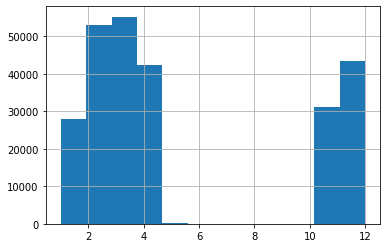

In [21]:
# Гистограмма активности по месяцам
train_df['time1'].dt.month.hist(bins=12)

<AxesSubplot:>

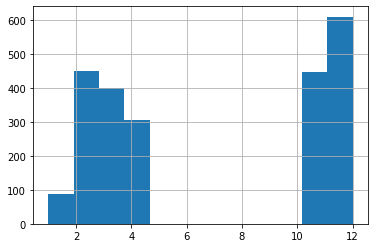

In [22]:
# Гистограмма активности Элис по месяцам
train_df[train_df['target'] == 1]['time1'].dt.month.hist(bins=12)

**Ответ:** 

- В среднем Элис проводит меньше времени на первой странице, чем другие пользователи - `Верно`;
- Медианная длительность посещения первой страницы у не-Элис больше, чем у Элис - `Ложно`;
- Лето является самым малоактивным временем года вообще - `Верно`;
- Элис наиболее активна в марте и неактивна летом - `Ложно`;

#### Чему равное медианное значение количества уникальных сайтов в рамках одной сессии обучающей выборки?

In [23]:
train_df['median'] = train_df[sites].apply(lambda x: x.unique().shape[0], axis=1)

In [24]:
train_df['median'].median()

6.0

**Ответ:** медианное значение количества уникальных сайтов в рамках одной сессии обучающей выборки = 6.

#### Чему равно медианное значение времени сессии в обучающей выборке (время посещения последнего сайта примем равным нулю)?

In [25]:
# Общее время сеанса
train_df['full_time'] = train_df[intervals].sum(axis=1)
test_df['full_time'] = test_df[intervals].sum(axis=1)

In [26]:
train_df['full_time'].median()

27.0

**Ответ:** Медианное значение времени сессии в обучающей выборке = 27 сек.

#### В каком месяце доля сессий Элис среди всех сессий наибольшая?

In [27]:
# Год, месяц, день
train_df['year'] = train_df['time1'].dt.year
train_df['month'] = train_df['time1'].dt.month
train_df['day'] = train_df['time1'].dt.day
train_df['week'] = train_df['time1'].dt.dayofweek
train_df['hour'] = train_df['time1'].dt.hour
# train_df['min'] = train_df['time1'].dt.minute

test_df['year'] = test_df['time1'].dt.year
test_df['month'] = test_df['time1'].dt.month
test_df['day'] = test_df['time1'].dt.day
test_df['week'] = test_df['time1'].dt.dayofweek
test_df['hour'] = test_df['time1'].dt.hour

<AxesSubplot:xlabel='month'>

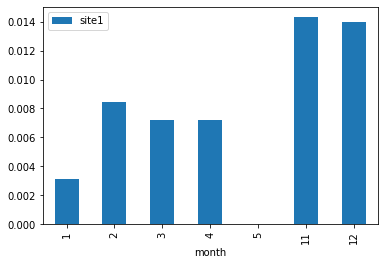

In [28]:
fract_month = train_df[train_df['target'] == 1][['site1', 'month']].groupby('month').count() / train_df[['site1', 'month']].groupby('month').count()
fract_month.plot(kind='bar')

**Ответ:** Доля сессий Элис среди всех сессий наибольшая в ноябре.

### Дополнительный анализ данных

Для выявления признаков по которым сессии Элис отличаются от остальных проведём дополнительный анализ:

#### Общее время сеанса

In [29]:
# Общее время сеанса остальных пользователей
train_df[train_df['target'] == 0]['full_time'].mean()

139.28237232552215

In [30]:
# Общее время сеанса Элис
train_df[train_df['target'] == 1]['full_time'].std()

153.30901405274358

In [31]:
train_df[train_df['target'] == 0]['full_time'].describe()

count    251264.000000
mean        139.282372
std         296.653518
min           0.000000
25%           7.000000
50%          28.000000
75%         114.000000
max        1800.000000
Name: full_time, dtype: float64

In [32]:
train_df[train_df['target'] == 1]['full_time'].describe()

count    2297.000000
mean       52.296474
std       153.309014
min         0.000000
25%         4.000000
50%        11.000000
75%        38.000000
max      1763.000000
Name: full_time, dtype: float64

<AxesSubplot:>

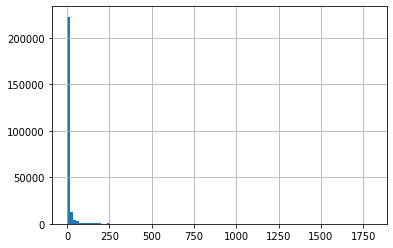

In [33]:
train_df['interval2'].hist(bins=100)

<AxesSubplot:>

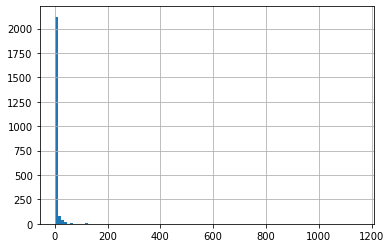

In [34]:
train_df[train_df['target'] == 1]['interval2'].hist(bins=100)

#### Анализ часов 

<AxesSubplot:>

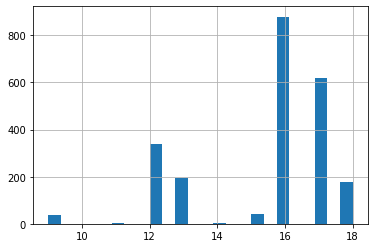

In [35]:
# Часы активности Элис
train_df[train_df['target'] == 1]['hour'].hist(bins=24)

<AxesSubplot:>

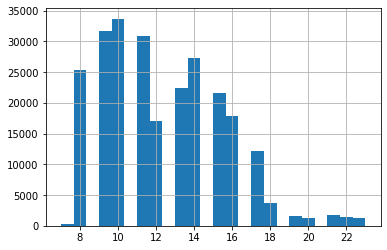

In [36]:
# Часы активности остальных пользователей
train_df[train_df['target'] == 0]['hour'].hist(bins=24)

**Вывод:** У элис есть любимые часы посещения сайтов.

#### Анализ дней

<AxesSubplot:>

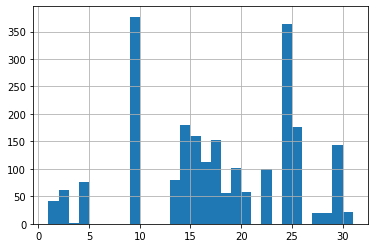

In [37]:
# Дни активности Элис
train_df[train_df['target'] == 1]['day'].hist(bins=30)

<AxesSubplot:>

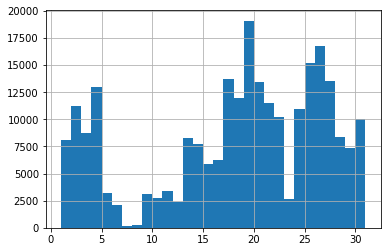

In [38]:
# Дни активности остальных пользователей
train_df[train_df['target'] == 0]['day'].hist(bins=30)

**Вывод:** Дни активности Элис не так явно выражены на фоне остальных пользователей.

#### Анализ дней недели 

<AxesSubplot:>

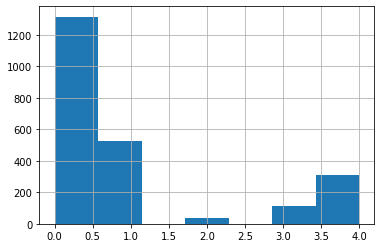

In [39]:
# Дни недели активности Элис
train_df[train_df['target'] == 1]['week'].hist(bins=7)

<AxesSubplot:>

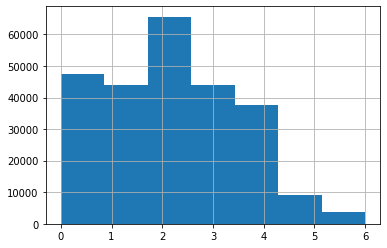

In [40]:
# Дни недели активности остальных пользователей
train_df[train_df['target'] == 0]['week'].hist(bins=7)

**Вывод:** Активность Элис по дням недели хорошо выделяются на фоне остальных пользователей.

#### Анализ месяцев

<AxesSubplot:>

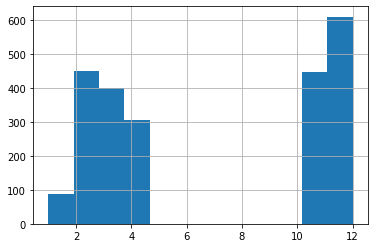

In [41]:
# Месяцы недели активности Элис
train_df[train_df['target'] == 1]['month'].hist(bins=12)

<AxesSubplot:>

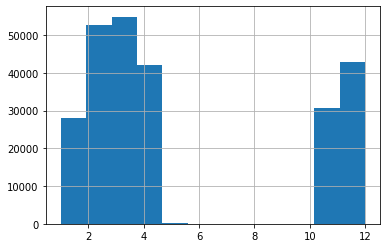

In [42]:
# Месяцы недели активности остальных пользователей
train_df[train_df['target'] == 0]['month'].hist(bins=12)

**Вывод:** Активность Элис по месяцам не отличается от остальных пользователей.

**Вывод:** 

Наибольшую перспективу имеют признаки на основе дней недели и часов.

#### Анализ повторяемости сайтов



## Создание признаков

### Борьба с дисбалансом

В тренировочном наборе данных записей с Элис в 100 раз меньше чем остальных. Это может привести к недообученности определять сессии Элис. Попробуем слегка исправить эту ситуацию увеличением выборки.

In [43]:
# Борьба с дисбалансом
# def upsample(features, target, repeat):
#     """ Функция принемает признаки, целевой признак, количество повторений единиц.
#         Возвращает увеличенную выборку
#     """
#     # Деление признаков на 0 и 1
#     features_zeros = features[target == 0]
#     features_ones  = features[target == 1]
#     target_zeros   = target[target == 0]
#     target_ones    = target[target == 1]
#     # Формирование фичей и таргета с увеличением единиц
#     features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
#     target_upsampled   = pd.concat([target_zeros] + [target_ones] * repeat)
#     # Перемешивание
#     features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
#     return features_upsampled, target_upsampled

In [44]:
# Создание увеличенной тренировочной выборки
# X_upsampled, y_upsampled = upsample(train_df.drop('target', axis=1), train_df['target'] , 2)

In [45]:
# train_df = X_upsampled
# train_df['target'] = y_upsampled

**Вывод:** Увеличение выборки не привело к увеличению качства модели.(

### Признаки по названиям сайтов

У Алисы есть свои любимые сайты, и чем чаще вы видите эти сайты в сеансе, тем выше вероятность того, что это сеанс Алисы, и наоборот.

Поскольку идентификаторы сайтов не имеют никакого значения (не имеет значения, имеет ли сайт идентификатор 1 или 100), нам нужно подумать о том, как закодировать значение "этот сайт в сеансе означает более высокую вероятность того, что это сеанс Alice".

Мы будем использовать технику, называемую ["bag of words plus n-gram model"](https://en.wikipedia.org/wiki/Bag-of-words_model).
В бейзлайне использовался векторизатор CountVectorizer. Я буду использовать векторизатор TF-IDF. Создадим матрицу "сайт-сессия", аналогичную матрице термин-документ.

In [46]:
# cv = CountVectorizer(ngram_range=(1, 3), max_features=50000)
# Вместо CountVectorizer применяем TfidfVectorizer
cv = TfidfVectorizer(ngram_range=(1, 5), max_features=100000)

TfidfVectorizer принимает "строки документов", поэтому подготовим строку наших "документов" (т.е. сайтов), разделенную пробелом. Поскольку строка будет огромной, мы запишем эту строку в текстовый файл с помощью pandas:

In [47]:
train_df[sites].fillna(0).to_csv('train_sessions_text.txt', 
                                 sep=' ', index=None, header=None)
test_df[sites].fillna(0).to_csv('test_sessions_text.txt', 
                                sep=' ', index=None, header=None)

Установим `TfidfVectorizer` для обучающих данных и преобразуем обучающие и тестовые данные с его помощью.

In [48]:
%%time

with open('train_sessions_text.txt') as inp_train_file:
    X_train_read = cv.fit_transform(inp_train_file)
with open('test_sessions_text.txt') as inp_test_file:
    X_test_read = cv.transform(inp_test_file)

print(X_train_read.shape, X_test_read.shape)

(253561, 100000) (82797, 100000)
CPU times: user 22.2 s, sys: 935 ms, total: 23.1 s
Wall time: 23.1 s


**Вывод**

Создана матрица признаков с помощью технологии TF-IDF.

### Работа с датой и временем

Добавление признаков на основе даты и времени:
1. Время нахождения на сайтах;
2. Общее время сеанса;

#### Время нахождения на сайтах

Добавляем в датасет время нахождения на сайтах

In [49]:
# время нахождения на сайтах остальных пользователей
train_df[train_df['target'] == 0][intervals].head()

,interval1,interval2,interval3,interval4,interval5,interval6,interval7,interval8,interval9
session_id,,,,,,,,,
27554,0.0,1.0,0.0,4.0,1.0,189.0,0.0,0.0,95.0
81350,0.0,800.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0
234665,1.0,1.0,0.0,1.0,0.0,3.0,3.0,0.0,2.0
97610,1.0,8.0,0.0,153.0,0.0,46.0,114.0,208.0,8.0
161358,1.0,103.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
# время нахождения Элис на сайтах
train_df[train_df['target'] == 1][intervals].head()

,interval1,interval2,interval3,interval4,interval5,interval6,interval7,interval8,interval9
session_id,,,,,,,,,
79635,147.0,339.0,1.0,1.0,19.0,0.0,3.0,0.0,1.0
11791,1.0,1.0,1.0,9.0,0.0,0.0,6.0,0.0,0.0
250238,0.0,1.0,6.0,0.0,0.0,9.0,10.0,2.0,0.0
72789,32.0,159.0,0.0,1.0,11.0,0.0,0.0,13.0,1.0
184885,21.0,133.0,0.0,0.0,24.0,1.0,1.0,0.0,10.0


#### Общее время сеанса

Среднее время сеанса у Элис и остальных пользователях отличается, поэтому создадим признак на основе полного времени сеанса

In [51]:
# Общее время сеанса больше 50?
train_df['full_time_f'] = train_df['full_time'].apply(lambda x: 0 if x < 50 else 1)
test_df['full_time_f'] = test_df['full_time'].apply(lambda x: 0 if x < 50 else 1)

In [52]:
# Время сайта 1 == 0 ?
train_df['site1_zero'] = train_df['interval1'].apply(lambda x: 1 if x == 0 else 0)
test_df['site1_zero']  = train_df['interval1'].apply(lambda x: 1 if x == 0 else 0)

In [53]:
# Время сайта 2 == 0 ?
train_df['site2_zero'] = train_df['interval2'].apply(lambda x: 1 if x == 0 else 0)
test_df['site2_zero']  = train_df['interval2'].apply(lambda x: 1 if x == 0 else 0)

#### День недели, час

Как видно из анализа данных, у Элис есть дни недели и часы в которые она пользуется интернетом больше чем в другие.

In [54]:
# Любимые часы Элис
def part_of_day(hour):
    if hour <= 8 or hour >= 19 or hour in [10, 11, 14]:
        return 0
    elif hour in [9, 15]:
        return 1
    elif hour in [12, 13, 18]:
        return 2
    else:
        return 3

train_df['part'] = train_df['hour'].apply(part_of_day)
test_df['part'] = test_df['hour'].apply(part_of_day)

In [55]:
# Любимые дни недели Элис
def part_of_week(week):
    if week >= 5:
        return 0
    elif week <=1:
        return 1
    else:
        return 2

train_df['part_week'] = train_df['week'].apply(part_of_week)
test_df['part_week'] = test_df['week'].apply(part_of_week)

In [56]:
train_df['part_week'].value_counts()

2    147667
1     93144
0     12750
Name: part_week, dtype: int64

In [57]:
# Так как это категориальные признаки, закодируем их по принципу OHE
ohe = OneHotEncoder(drop='first')
# ymw = ['year', 'month', 'week']
# ymw = ['month', 'week']
# ymw = ['week', 'hour']
ymw = ['part_week', 'part']
ohe.fit(train_df[ymw])
time_train = ohe.transform(train_df[ymw])
time_test = ohe.transform(test_df[ymw])

In [58]:
time_test

<82797x5 sparse matrix of type '<class 'numpy.float64'>'
	with 120272 stored elements in Compressed Sparse Row format>

In [59]:
time_train

<253561x5 sparse matrix of type '<class 'numpy.float64'>'
	with 369631 stored elements in Compressed Sparse Row format>

**Вывод:**

Наиболее эфективны оказались признаки на основе любимых дней недели и часов.

### Сайты

Попытаемся извлечь признаки из отличий у Элис в предпочтениях сайтов и их посторяемости.

#### Самые часто повторяемые сайты



In [60]:
def top_site(site):
    if site in top_site1.index:
        return top_site1[site]
    else:
        return 0

In [61]:
# Топ первых сайтов Элис
top_site1 = train_df[train_df['target'] == 1].site1.value_counts().head()

train_df['top_site1'] = train_df['site1'].apply(lambda x: x in top_site1)
test_df['top_site1'] = test_df['site1'].apply(lambda x: x in top_site1)

In [62]:
train_df[train_df['target'] == 0].site1

session_id
27554     41475
81350     41476
234665     4802
97610        23
161358    41476
          ...  
129606     6003
53628      6003
84754      6003
153398     6003
11690       305
Name: site1, Length: 251264, dtype: int64

In [63]:
train_df[train_df['target'] == 1].site1

session_id
79635       270
11791      7832
250238     7832
72789        29
184885       29
          ...  
188473       37
40139        29
205622    18728
60720         2
244233       12
Name: site1, Length: 2297, dtype: int64

In [64]:
# Топ вторых сайтов Элис
top_site2 = train_df[train_df['target'] == 1].site2.value_counts().head().index.values

train_df['top_site2'] = train_df['site2'].apply(lambda x: x in top_site2)
test_df['top_site2'] = test_df['site2'].apply(lambda x: x in top_site2)

In [65]:
stsc = StandardScaler()
top = ['top_site1','top_site2']
stsc.fit(train_df[top])
train_df[top] = stsc.transform(train_df[top])
test_df[top] = stsc.transform(test_df[top])

In [66]:
train_df.top_site1.sum()

2.5579538487363607e-12

#### Используемые сайты

In [67]:
site_use = ['su'+str(i) for i in range(1, 11)]

In [68]:
for i in range(1, 10):
    train_df[site_use[i]] = train_df[times[i]].isna()
    test_df[site_use[i]] = test_df[times[i]].isna()

In [69]:
site_use

['su1', 'su2', 'su3', 'su4', 'su5', 'su6', 'su7', 'su8', 'su9', 'su10']

In [70]:
train_df['su2'].value_counts()

False    253561
Name: su2, dtype: int64

In [71]:
train_df[train_df['target'] == 1]['su2'].value_counts()

False    2297
Name: su2, dtype: int64

#### Количество сайтов в сессии

In [72]:
def s_counts(row):
    sites_c = row.value_counts()
    sites_c = sites_c[sites_c.index != 0]
    result = sites_c[:2].values
    if len(result) == 1:
        return result[0], 0
    return result[0], result[1]

In [73]:
site_counts = ['site_count1', 'site_count2']

In [74]:
%%time
site_count_train = train_df[sites].apply(s_counts, axis=1, result_type='expand')
site_count_test  =  test_df[sites].apply(s_counts, axis=1, result_type='expand')

CPU times: user 2min 47s, sys: 371 ms, total: 2min 48s
Wall time: 2min 49s


In [75]:
train_df[site_counts] = site_count_train

In [76]:
train_df['site_count3'] = train_df[site_counts].apply(sum, axis=1)

<AxesSubplot:>

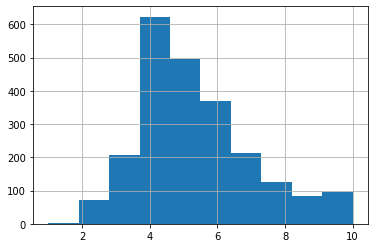

In [77]:
train_df[train_df['target'] == 1]['site_count3'].hist()

<AxesSubplot:>

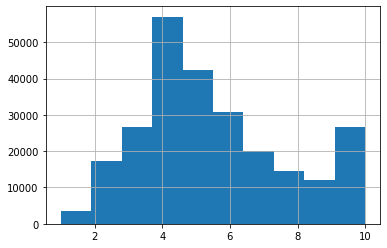

In [78]:
train_df[train_df['target'] == 0]['site_count3'].hist()

In [79]:
train_df.loc[72789, sites].value_counts()

7832    3
29      3
30      3
37      1
Name: 72789, dtype: int64

**Вывод:**

Признаки на основе сайтов себя не оправдали. Скорее всего это связано с тем, что в матрице признаков по названиям сайтов и так эти закономерности представлены.

## Создание моделей

1. Соединим все созданные признаки вместе;
2. Обучим модель на обучающей выборке = 90% тренировочного набора данных и проверим на оставшихся 10%;
3. Проверим модель с помощью кросвалидации;
4. Подберём оптимальные гиперпараметры модели;
5. Обучим модель на всём тренировочном наборе данных и запишем предсказания в файл.

In [80]:
X_train= X_train_read

In [81]:
X_test =X_test_read

### Собираем признаки 

In [82]:
# Добавляем к наборам данных данные по дню недели и часам
X_train = hstack((X_train_read, time_train)).tocsr()
X_test  = hstack((X_test_read,  time_test )).tocsr()

In [83]:
# features_column = ['full_time_f', 'top_site1', 'site1_zero', 'site2_zero']
features_column = ['full_time_f', 'site1_zero', 'top_site1']

In [84]:
# Добавляем признаки
X_train = hstack((X_train, train_df[features_column].values)).tocsr()
X_test  = hstack((X_test,   test_df[features_column].values)).tocsr()

In [85]:
# Проверка размера тренировочной выборки
X_train

<253561x100008 sparse matrix of type '<class 'numpy.float64'>'
	with 5051929 stored elements in Compressed Sparse Row format>

In [86]:
# Проверка размера тестовой выборки
X_test

<82797x100008 sparse matrix of type '<class 'numpy.float64'>'
	with 1542062 stored elements in Compressed Sparse Row format>

In [87]:
# Целевой признак
y_train = train_df['target'].values

### Тренировка моделей

Здесь я не буду приводить мои безуспешные попытки получить результат лучше чем у линейной регрессии на моделях CatBoost и XGBRegreccor. Остановлюсь на Линейной регрессии, тем более что стояла именно такая задача.

In [88]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    
    # Разделим данные на обучающие и проверочные наборы
    idx = int(round(X.shape[0] * ratio))
    
    # Обучение модели классификации
    lr = LogisticRegression(C=C, 
                            random_state=seed,
                            solver='lbfgs', 
                            max_iter=2000,
                            class_weight='balanced'
                           ).fit(X[:idx, :], y[:idx])

    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    
    # Рассчёт метрики качества
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [89]:
def get_auc_cv_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    
    # Обучение модели классификации
    lr = LogisticRegression(C=C, 
                            random_state=seed,
                            solver='lbfgs', 
                            max_iter=2000,
#                             class_weight='balanced'
                           )
   
    score = cross_val_score(lr, X, y, cv=5, scoring='roc_auc').mean()
    return score

In [90]:
%%time
# Вычислим метрику по набору проверки. 90% обучающих данных для обучения. 10% для проверки

print(get_auc_lr_valid(X_train, y_train, C=1))

0.9822303921568627
CPU times: user 1min 20s, sys: 1min 35s, total: 2min 55s
Wall time: 2min 56s


In [91]:
# 0.9829507714640426 0.981183487191378 0.9816076837238961 

In [92]:
%%time
# Вычислим метрику по набору проверки. 90% обучающих данных для обучения. 10% для проверки 0.9234225758178558
# 0.8984823851277461 0.9023839303231123 0.948110277016218 0.9493448448296651 0.9525370185357229

print(get_auc_cv_valid(X_train, y_train, C=5))

0.9524280721272715
CPU times: user 5min 57s, sys: 7min 16s, total: 13min 14s
Wall time: 13min 15s


**Вывод:**  При значении метрики auc-roc = 0.9524, получил на открытой тестовой выборке 0,964867, на закрытой 0,958693

### GridSearchCV

In [93]:
# %%time
# # Логистическая регрессия с автоподбором параметров для целевого признака final.output.recovery
# parametrs = { 'C': [0.1, 0.5, 0.8, 1, 2, 3, 5, 7]}

# lr = LogisticRegression(    random_state=17,
#                             solver='lbfgs', 
#                             max_iter=500,
# #                           class_weight='balanced'
#                        )
# GridCV = GridSearchCV(lr, parametrs, scoring='roc_auc', cv=5)
# GridCV.fit(X_train, y_train)
# print('Параметры модели:', GridCV.best_params_)
# print('Лучший AUC-ROC модели:', GridCV.best_score_)

**Вывод:** Лучшее значение гиперпараметра С = 5.

### CatBoost

In [94]:
# %%time
# # CatBoost с автоподбором параметров для целевого признака final.output.recovery
# parametrs = { 'l2_leaf_reg': randint(1,10),
#               'learning_rate': [0.005, 0.01, 0.02, 0.05, 0.06, 0.07, 0.08, 0.1, 0.2, 0.5, 0.8, 1],
#                'depth' : randint(1,10)}

# cat_final = CatBoostClassifier(iterations=200, silent = True)
# randCV_cat_final = RandomizedSearchCV(cat_final, parametrs, scoring='roc_auc', cv=4, n_iter=10, random_state=17)
# randCV_cat_final.fit(X_train, y_train)
# print('Параметры модели:', randCV_cat_final.best_params_)
# print('Лучший AUC-ROC модели:', randCV_cat_final.best_score_)

**Вывод:** CatBoost себя не оправдал. Максимальный AUC-ROC модели: 0.87504

### Запись результата

In [95]:
# Функция для записи прогнозов в файл
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = range(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [96]:
# Обучаем модель по всему набору обучающих данных
# Use random_state=17 for reproducibility
# Параметр C=5
# Параметр class_weight='balanced'

lr = LogisticRegression(C=5, 
                        random_state=17, 
                        solver='lbfgs', 
                        max_iter=2000, 
                        class_weight='balanced'
                       ).fit(X_train, y_train
                       )

# Обучаем модель по всему набору обучающих данных
y_test = lr.predict_proba(X_test)[:, 1]

In [98]:
# Запишим прогнозы в файл, который будет отправлен
write_to_submission_file(y_test, 'baseline_1_40.csv')

**Вывод**

Из анализа данных стало ясно, что Элис давольно сильно отличается от остальных пользователей по характеру действий в интернете. Основой набора признаков стали векторизированные названия сайтов. Именно это вносит наибольший вклад в качество модели. Перебрав множество вариантов дополнительных признаков на основе времнных данных сессий и повторяемости сайтов, наибольшую эффективность показали: - любимые дни недели, любимые часы, топ любимых сайтов и нулевое время первого сайта в сессии.

В задании на курсе по линейным моделям было рекомендовано использовать только линейную регрессию. Попробовал применить к задаче модель CatBoostClassifier и XGBoostClassifier, но добиться от них качества выше чем у LogisticRegression не удалось.

Модель из baseline продемонстрировала качество 0,9235 в наборе проверки. Мне удалось увеличить качество до 0,964867 на открытой тестовой выборке и 0,958693 на закрытой. 